In [1]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.interpolate import interp1d

from shapely import LineString

from pyCivilDesign.sections.concreteSections import showSection, RectConcreteSct
import pyCivilDesign.sections.rebarSections as Rsct
import pyCivilDesign.sections.section as Sct
import pyCivilDesign.concreteDesign.LRFDmethod.PMManalysis as PMManalysis
import pyCivilDesign.concreteDesign.designProps as props

In [2]:
d20 = Rsct.d20

sct = RectConcreteSct(b=500, h=700)
sct.rebarCoords = Rsct.RectRebarsSct(sct.section, 5, 4, d20, 50)

data = props.setDesignDataFromSection(sct)

In [72]:
def calc_Pc_list(data, angle, interval=20):
    c_list = np.array([0,], dtype=np.float32)
    P_list = np.array([PMManalysis.calc_Pt_max(data),], dtype=np.float32)
    c=0.1
    while True:
        _P = PMManalysis.calc_P(data, c, angle)
        c_list = np.append(c_list, c)
        P_list = np.append(P_list, _P)
        if _P > PMManalysis.calc_P0(data): break
        c += interval
    return P_list, c_list


def calc_PM_list(data, angle):
    P_list, c_list = calc_Pc_list(data, angle)
    M_list = np.array([PMManalysis.calc_M(data, _c, angle) for _c in c_list], dtype=np.float32)
    M_list.reshape(-1, 3)
    return P_list, M_list


def calc_Mn(data, P, angle):
    c = np.interp(P, *calc_Pc_list(data, angle))
    return PMManalysis.calc_M(data, c, angle) # type: ignore


def calc_PM_ratio(data, P, Mx, My, angle):
    M = pow(Mx**2 + My**2, 0.5)
    e = M/P
    P_list, M_list = calc_PM_list(data, angle)
    M_custom = np.max(M_list[:,0]) * 1.1
    P_custom = M_custom/e

    PM_line = LineString(list(zip(M_list[:,0], P_list)))
    PMx_line = LineString([(0, 0), (M_custom, P_custom)])
    
    inter_point = PM_line.intersection(PMx_line)
    _M = inter_point.x
    _P = inter_point.y
    return P/_P if P!=0 else M/_M


def calc_percent(data, P, Mx, My, ratio=1, num=8):
    angle = PMManalysis.calc_angle_from_forces(data, P, Mx, My)
    data_one_percent = PMManalysis.set_As_percent(data, 1)
    data_eight_percent = PMManalysis.set_As_percent(data, 8)
    if calc_PM_ratio(data_one_percent, P, Mx, My, angle) <= 1: 
        output_percent = 1
    elif calc_PM_ratio(data_eight_percent, P, Mx, My, angle) > 1:
        raise ValueError("section is weak")
    else:
        percent_list = np.linspace(1, 8, num=num, dtype=np.float32)
        data_list = np.array([PMManalysis.set_As_percent(data, percent) for percent in percent_list])
        PM_ratio_list = np.array([calc_PM_ratio(_data, P, Mx, My, angle) for _data in data_list], dtype=np.float32)
        func = interp1d(PM_ratio_list, percent_list)
        output_percent = func(ratio)
    return output_percent


def calc_angle_from_forces(data, P, Mx, My, num=40):
    alpha = PMManalysis.calc_alpha(Mx, My)
    angle_list = np.linspace(0, 360, num=num)
    M_list = np.array([calc_Mn(data, P, _angle) for _angle in angle_list])
    alpha_list = np.array([PMManalysis.calc_alpha(_M[1], _M[2]) for _M in M_list])
    return np.interp(alpha, alpha_list, angle_list)
    

In [73]:
Pu = 4e6
Mux = 5e8
Muy = 4e8

Mu = pow(Mux**2 + Muy**2, 0.5)
angle = PMManalysis.calc_angle_from_forces(data, Pu, Mux, Muy)
e = Mu/Pu

P_list, M_list = calc_PM_list(data, angle)
calc_PM_ratio(data, Pu, Mux, Muy, angle)

1.0698393380598108

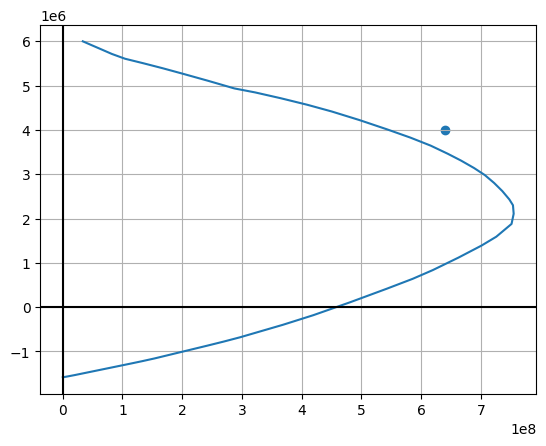

In [74]:
fig, axs = plt.subplots()
axs.plot(M_list[:,0], P_list)
axs.scatter(Mu, Pu)
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.grid(True)
plt.show()

In [75]:
calc_percent(data, Pu, Mux, Muy)

array(1.71415166)

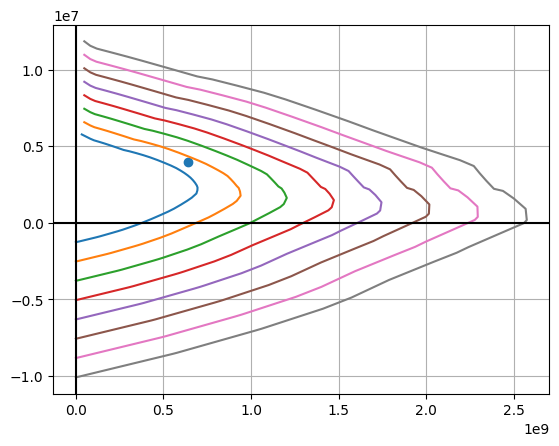

In [76]:
percent_list = np.linspace(1, 8, num=8)
data_list = np.array([PMManalysis.set_As_percent(data, percent) for percent in percent_list])

fig, axs = plt.subplots()
for _data in data_list:
    P_list, M_list = calc_PM_list(_data, angle)
    axs.plot(M_list[:,0], P_list)
axs.scatter(Mu, Pu)
axs.axhline(y=0, color='k', linestyle='-')
axs.axvline(x=0, color='k', linestyle='-')
axs.grid(True)
plt.show()